# 2D

In [ ]:
import random
import numpy as np
import re
from typing import List, Tuple, Dict, Set
import copy
from dataclasses import dataclass

@dataclass
class Solution:
    sequence: str
    positions: List[Tuple[int, int]]
    amino_positions: Dict[Tuple[int, int], str]
    contacts: int = 0

class ImprovedHPFolding:
    def __init__(self,
                 n_ants: int = 50,
                 n_iterations: int = 200,
                 alpha: float = 1.5,
                 beta: float = 2.5,
                 rho: float = 0.15,
                 q0: float = 0.85,
                 temperature: float = 100.0,
                 cooling_rate: float = 0.95):
        self.directions = [(0, 1), (1, 0), (0, -1), (-1, 0)]
        self.grid_size = 100
        self.grid = [[None for _ in range(self.grid_size)] for _ in range(self.grid_size)]

        self.n_ants = n_ants
        self.n_iterations = n_iterations
        self.alpha = alpha
        self.beta = beta
        self.rho = rho
        self.q0 = q0
        self.pheromone = {}
        self.temperature = temperature
        self.cooling_rate = cooling_rate

        self.best_solution = None
        self.best_fitness = float('-inf')
        self.solution_memory = []

    def expand_sequence(self, sequence: str) -> str:
        if not sequence:
            return ""

        while '(' in sequence:
            sequence = re.sub(r'\(([^)]+)\)(\d+)',
                            lambda m: m.group(1) * int(m.group(2)),
                            sequence)

        sequence = re.sub(r'(H|P)(\d+)',
                         lambda m: m.group(1) * int(m.group(2)),
                         sequence)
        return sequence

    def initialize_pheromone(self):
        self.pheromone = {}
        for x in range(self.grid_size):
            for y in range(self.grid_size):
                for direction in self.directions:
                    self.pheromone[((x, y), direction)] = 1.0

    def get_heuristic_info(self, pos: Tuple[int, int], next_pos: Tuple[int, int],
                          used_positions: Set[Tuple[int, int]], amino: str) -> float:
        if next_pos in used_positions:
            return 0.0

        h_count = 0
        if amino == 'H':
            for dx, dy in self.directions:
                check_pos = (next_pos[0] + dx, next_pos[1] + dy)
                if check_pos in used_positions:
                    h_count += 1

        return 1.0 + h_count

    def count_hh_contacts(self, positions: List[Tuple[int, int]],
                         amino_positions: Dict[Tuple[int, int], str]) -> int:
        if not positions or not amino_positions:
            return 0

        contacts = 0
        sequence_pos_list = list(positions)

        for i, pos in enumerate(sequence_pos_list):
            if amino_positions[pos] != 'H':
                continue

            for dx, dy in self.directions:
                neighbor = (pos[0] + dx, pos[1] + dy)
                if (neighbor in amino_positions and
                    amino_positions[neighbor] == 'H'):
                    if i > 0 and sequence_pos_list[i-1] == neighbor:
                        continue
                    if i < len(sequence_pos_list)-1 and sequence_pos_list[i+1] == neighbor:
                        continue
                    contacts += 1

        return contacts // 2

    def try_rotate(self, positions: List[Tuple[int, int]], index: int) -> List[Tuple[int, int]]:
        if index <= 0 or index >= len(positions) - 1:
            return None

        new_positions = positions.copy()
        prev_pos = positions[index - 1]
        curr_pos = positions[index]
        next_pos = positions[index + 1]

        for dx, dy in self.directions:
            new_pos = (prev_pos[0] + dx, prev_pos[1] + dy)
            if (new_pos != curr_pos and
                new_pos not in positions and
                self.is_valid_connection(new_pos, next_pos)):
                new_positions[index] = new_pos
                return new_positions
        return None

    def is_valid_connection(self, pos1: Tuple[int, int], pos2: Tuple[int, int]) -> bool:
        dx = abs(pos1[0] - pos2[0])
        dy = abs(pos1[1] - pos2[1])
        return (dx == 1 and dy == 0) or (dx == 0 and dy == 1)

    def local_optimize(self, solution: Solution) -> Solution:
        improved = True
        current_solution = copy.deepcopy(solution)

        while improved:
            improved = False
            for i in range(1, len(current_solution.positions) - 1):
                new_positions = self.try_rotate(current_solution.positions, i)
                if new_positions:
                    # amino_positions
                    new_amino_positions = {}
                    for j, pos in enumerate(new_positions):
                        new_amino_positions[pos] = current_solution.sequence[j]

                    new_contacts = self.count_hh_contacts(new_positions, new_amino_positions)
                    if new_contacts > current_solution.contacts:
                        current_solution.positions = new_positions
                        current_solution.amino_positions = new_amino_positions
                        current_solution.contacts = new_contacts
                        improved = True

        return current_solution

    def simulated_annealing(self, solution: Solution) -> Solution:
        current_solution = copy.deepcopy(solution)
        best_solution = copy.deepcopy(solution)
        temperature = self.temperature

        while temperature > 1.0:
            for _ in range(len(solution.positions)):
                i = random.randint(1, len(solution.positions) - 2)
                new_positions = self.try_rotate(current_solution.positions, i)

                if new_positions:
                    new_amino_positions = {}
                    for j, pos in enumerate(new_positions):
                        new_amino_positions[pos] = current_solution.sequence[j]

                    new_contacts = self.count_hh_contacts(new_positions, new_amino_positions)
                    delta = new_contacts - current_solution.contacts

                    if delta > 0 or random.random() < np.exp(delta / temperature):
                        current_solution.positions = new_positions
                        current_solution.amino_positions = new_amino_positions
                        current_solution.contacts = new_contacts

                        if current_solution.contacts > best_solution.contacts:
                            best_solution = copy.deepcopy(current_solution)

            temperature *= self.cooling_rate

        return best_solution

    def hybrid_optimize(self, sequence: str) -> Solution:
      expanded_sequence = self.expand_sequence(sequence)
      self.initialize_pheromone()

      initial_q0 = self.q0
      initial_beta = self.beta

      for restart in range(1):
          print(f"\nstart {restart + 1} reboot...")

          # reset params
          self.q0 = initial_q0
          self.beta = initial_beta

          # ACO
          for iteration in range(self.n_iterations):
              progress = iteration / self.n_iterations
              self.q0 = 0.9 * progress + 0.1
              self.beta = 2.5 + progress * 1.0

              solutions = []
              iteration_best = None
              iteration_best_contacts = -1

              for ant in range(self.n_ants):
                  solution = self.construct_solution(expanded_sequence)
                  if solution:
                      solution = self.local_optimize(solution)
                      solutions.append(solution)

                      if solution.contacts > iteration_best_contacts:
                          iteration_best = solution
                          iteration_best_contacts = solution.contacts

                      if solution.contacts > self.best_fitness:
                          self.best_fitness = solution.contacts
                          self.best_solution = copy.deepcopy(solution)
                          print(f"gen {iteration}, found best = {solution.contacts}")

              if solutions:
                  self.update_pheromone(solutions)

                  if iteration_best:
                      self.reinforce_best_solution(iteration_best, factor=0.3)

              if iteration % 10 == 0:
                  print(f"finish {iteration}, "
                        f"best solutioin: {self.best_fitness}, "
                        f"q0: {self.q0:.2f}, "
                        f"beta: {self.beta:.2f}")

          if self.best_solution:
              print(f"\nreboot {restart + 1}finish...")
              improved_solution = self.simulated_annealing(self.best_solution)
              if improved_solution.contacts > self.best_fitness:
                  self.best_solution = improved_solution
                  self.best_fitness = improved_solution.contacts
                  print(f"reboot，H-H count = {self.best_fitness}")

      return self.best_solution

    def reinforce_best_solution(self, solution: Solution, factor: float = 0.3):
        positions = solution.positions
        delta = solution.contacts / (1 + solution.contacts) * factor

        for i in range(len(positions) - 1):
            pos = positions[i]
            next_pos = positions[i + 1]
            direction = (next_pos[0] - pos[0], next_pos[1] - pos[1])
            self.pheromone[(pos, direction)] += delta

    def construct_solution(self, sequence: str) -> Solution:
        center = self.grid_size // 2
        current_pos = (center, center)
        used_positions = {current_pos}
        sequence_positions = [current_pos]
        amino_positions = {current_pos: sequence[0]}

        for amino in sequence[1:]:
            valid_directions = []
            for dx, dy in self.directions:
                next_pos = (current_pos[0] + dx, current_pos[1] + dy)
                if self.is_valid_position(next_pos[0], next_pos[1], used_positions):
                    valid_directions.append((dx, dy))

            if not valid_directions:
                return None

            direction = self.select_direction(current_pos, valid_directions, used_positions, amino)
            if not direction:
                return None

            current_pos = (current_pos[0] + direction[0], current_pos[1] + direction[1])
            used_positions.add(current_pos)
            sequence_positions.append(current_pos)
            amino_positions[current_pos] = amino

        contacts = self.count_hh_contacts(sequence_positions, amino_positions)
        return Solution(sequence, sequence_positions, amino_positions, contacts)
    def is_valid_position(self, x: int, y: int, used_positions: Set[Tuple[int, int]]) -> bool:

        return (0 <= x < self.grid_size and
                0 <= y < self.grid_size and
                (x, y) not in used_positions)

    def select_direction(self, current_pos: Tuple[int, int],
                        valid_directions: List[Tuple[int, int]],
                        used_positions: Set[Tuple[int, int]],
                        amino: str) -> Tuple[int, int]:
        if not valid_directions:
            return None

        probabilities = []
        for dx, dy in valid_directions:
            next_pos = (current_pos[0] + dx, current_pos[1] + dy)
            tau = self.pheromone.get((current_pos, (dx, dy)), 1.0)
            eta = self.get_heuristic_info(current_pos, next_pos, used_positions, amino)

            if random.random() < self.q0:
                probabilities.append((tau ** self.alpha) * (eta ** self.beta))
            else:
                probabilities.append(random.random() * tau * eta)

        max_prob_index = np.argmax(probabilities)
        return valid_directions[max_prob_index]
    def update_pheromone(self, solutions: List[Solution]):
      for key in self.pheromone:
          self.pheromone[key] *= (1 - self.rho)

      solutions.sort(key=lambda sol: sol.contacts, reverse=True)
      elite_count = max(1, int(self.n_ants * 0.1))
      for i, solution in enumerate(solutions[:elite_count]):
          delta = solution.contacts / (1 + solution.contacts)
          positions = solution.positions
          rank_weight = 1.0 - i*(0.1)
          for i in range(len(positions) - 1):
              pos = positions[i]
              next_pos = positions[i + 1]
              direction = (next_pos[0] - pos[0], next_pos[1] - pos[1])
              self.pheromone[(pos, direction)] += delta * rank_weight


      if self.best_solution:
          delta_global = self.best_solution.contacts / (1 + self.best_solution.contacts)
          for i in range(len(self.best_solution.positions) - 1):
              pos = self.best_solution.positions[i]
              next_pos = self.best_solution.positions[i + 1]
              direction = (next_pos[0] - pos[0], next_pos[1] - pos[1])
              self.pheromone[(pos, direction)] += delta_global * 0.5


    def visualize(self, solution: Solution) -> str:

        if not solution or not solution.positions:
            return None

        positions = solution.positions
        amino_positions = solution.amino_positions

        min_x = min(x for x, _ in positions)
        max_x = max(x for x, _ in positions)
        min_y = min(y for _, y in positions)
        max_y = max(y for _, y in positions)

        grid_height = (max_x - min_x + 1) * 2 - 1
        grid_width = (max_y - min_y + 1) * 2 - 1
        grid = [[' ' for _ in range(grid_width)] for _ in range(grid_height)]

        pos_map = {}
        for i, pos in enumerate(positions):
            new_x = (pos[0] - min_x) * 2
            new_y = (pos[1] - min_y) * 2
            pos_map[pos] = (new_x, new_y)
            grid[new_x][new_y] = amino_positions[pos]

            if i < len(positions) - 1:
                next_pos = positions[i + 1]
                curr_x, curr_y = pos_map[pos]
                next_x = (next_pos[0] - min_x) * 2
                next_y = (next_pos[1] - min_y) * 2

                if next_x == curr_x:
                    mid_y = (curr_y + next_y) // 2
                    grid[curr_x][mid_y] = '-'
                else:
                    mid_x = (curr_x + next_x) // 2
                    grid[mid_x][curr_y] = '|'

        for i, pos1 in enumerate(positions):
            if amino_positions[pos1] != 'H':
                continue

            new_x1, new_y1 = pos_map[pos1]
            for dx, dy in [(0, 2), (2, 0), (0, -2), (-2, 0)]:
                check_x, check_y = new_x1 + dx, new_y1 + dy

                for j, pos2 in enumerate(positions):
                    new_x2, new_y2 = pos_map[pos2]
                    if ((new_x2, new_y2) == (check_x, check_y) and
                        amino_positions[pos2] == 'H' and
                        abs(i - j) > 1):
                        mid_x = (new_x1 + new_x2) // 2
                        mid_y = (new_y1 + new_y2) // 2
                        if grid[mid_x][mid_y] == ' ':
                            grid[mid_x][mid_y] = '*'


        lines = [''.join(row).rstrip() for row in grid]
        while lines and not lines[0].strip():
            lines.pop(0)
        while lines and not lines[-1].strip():
            lines.pop()

        min_leading_spaces = min(len(line) - len(line.lstrip())
                               for line in lines if line.strip())
        lines = [line[min_leading_spaces:] for line in lines]

        return '\n'.join(lines)

def main():
    sequence = "(HP)2PH2PHP2HPH2P2HPH"

    hp_folder = ImprovedHPFolding(
        n_ants=50,
        n_iterations=100,
        alpha=1.5,
        beta=2.5,
        rho=0.15,
        q0=0.85,
        temperature=100.0,
        cooling_rate=0.95
    )

    print("init...")
    best_solution = hp_folder.hybrid_optimize(sequence)

    if best_solution:
        print("\nbest solution:")
        print(f"H-H count: {best_solution.contacts}")
        print("\nsolution:")
        print(hp_folder.visualize(best_solution))
    else:
        pass

if __name__ == "__main__":
    main()

init...

start 1 reboot...
gen 0, found best = 1
gen 0, found best = 3
gen 0, found best = 5
finish 0, best solutioin: 5, q0: 0.10, beta: 2.50
gen 2, found best = 6
gen 4, found best = 8
finish 10, best solutioin: 8, q0: 0.19, beta: 2.60
finish 20, best solutioin: 8, q0: 0.28, beta: 2.70
finish 30, best solutioin: 8, q0: 0.37, beta: 2.80
finish 40, best solutioin: 8, q0: 0.46, beta: 2.90
finish 50, best solutioin: 8, q0: 0.55, beta: 3.00
finish 60, best solutioin: 8, q0: 0.64, beta: 3.10
finish 70, best solutioin: 8, q0: 0.73, beta: 3.20
finish 80, best solutioin: 8, q0: 0.82, beta: 3.30
finish 90, best solutioin: 8, q0: 0.91, beta: 3.40

reboot 1finish...

best solution:
H-H count: 8

solution:
    P-P
    | |
  P-H*H-H-P
  | *   * |
H*H*H-P-H*H
| * |   | |
P-H*H   P-P
  | |
  P-P


# 3D

init...

start 1 reboot...
gen 0, better solution = 6
gen 0, better solution = 11
gen 0, better solution = 12
gen 0, better solution = 16
finish 0, best HH count now: 16, q0: 0.10, beta: 2.50
gen 10, better solution = 17
finish 10, best HH count now: 17, q0: 0.55, beta: 3.00
gen 17, better solution = 18

reboot1 ...
after reboot, HH count = 19

found best:
HH count: 19

solution:


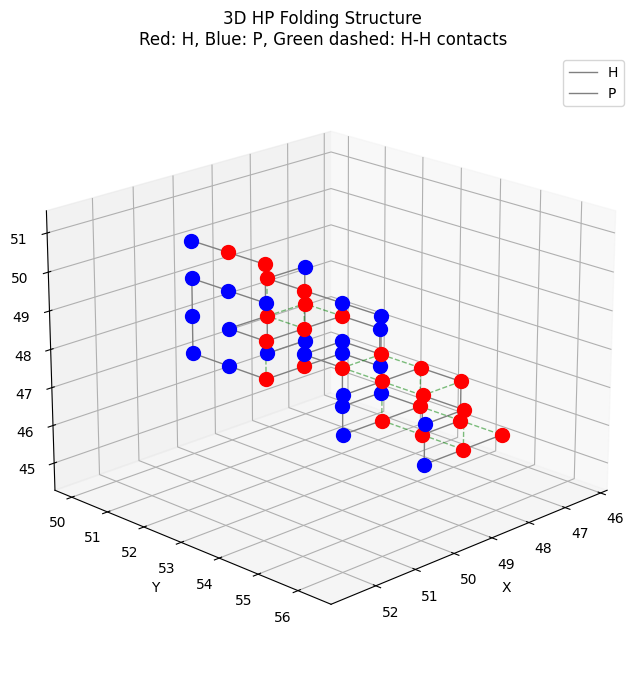


layer 47:
  • P-•
  | |
  P H   P-H*H*H
    |   | | | |
P-P-H   P H*•*H
          |   |
          •   P

layer 48:
  •*H-P
  * |
  H*H P-H*H-•
  | | | * | *
• P-H P-•*H*H-H
          |   |
          P   •

layer 49:
  P
  |
  H-H-P-•

•-P-P

layer 50:
P-H-•


In [ ]:
import random
import numpy as np
import re
from typing import List, Tuple, Dict, Set
import copy
from dataclasses import dataclass
%matplotlib inline

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

@dataclass
class Solution3D:
    sequence: str
    positions: List[Tuple[int, int, int]]  # 3D positions
    amino_positions: Dict[Tuple[int, int, int], str]
    contacts: int = 0


class ImprovedHPFolding3D:
    def __init__(self,
                 n_ants: int = 50,
                 n_iterations: int = 200,
                 alpha: float = 1.5,
                 beta: float = 2.5,
                 rho: float = 0.15,
                 q0: float = 0.85,
                 temperature: float = 100.0,
                 cooling_rate: float = 0.95):
        self.directions = [(0,1,0), (1,0,0), (0,-1,0), (-1,0,0), (0,0,1), (0,0,-1)]
        self.grid_size = 100
        self.grid = [[[None for _ in range(self.grid_size)]
                     for _ in range(self.grid_size)]
                     for _ in range(self.grid_size)]

        # ACO param
        self.n_ants = n_ants
        self.n_iterations = n_iterations
        self.alpha = alpha
        self.beta = beta
        self.rho = rho
        self.q0 = q0
        self.pheromone = {}
        self.temperature = temperature
        self.cooling_rate = cooling_rate
        self.best_solution = None
        self.best_fitness = float('-inf')
        self.current_sequence = ""
        self.amino_positions = {}
        self.current_index = 0


    def expand_sequence(self, sequence: str) -> str:
        if not sequence:
            return ""

        while '(' in sequence:
            sequence = re.sub(r'\(([^)]+)\)(\d+)',
                            lambda m: m.group(1) * int(m.group(2)),
                            sequence)

        sequence = re.sub(r'(H|P)(\d+)',
                         lambda m: m.group(1) * int(m.group(2)),
                         sequence)
        return sequence

    def initialize_pheromone(self):
        self.pheromone = {}
        for x in range(self.grid_size):
            for y in range(self.grid_size):
                for z in range(self.grid_size):
                    for direction in self.directions:
                        self.pheromone[((x,y,z), direction)] = 1.0

    def get_heuristic_info(self, pos: Tuple[int, int, int],
                          next_pos: Tuple[int, int, int],
                          used_positions: Set[Tuple[int, int, int]],
                          amino: str) -> float:
        if next_pos in used_positions:
            return 0.0

        h_count = 0
        if amino == 'H':
            for dx, dy, dz in self.directions:
                check_pos = (next_pos[0] + dx, next_pos[1] + dy, next_pos[2] + dz)
                if check_pos in used_positions and self.amino_positions.get(check_pos) == 'H':
                    h_count += 1

        future_h_ratio = self.estimate_future_h_ratio()
        heuristic = (1.0 + h_count) * (1.0 + future_h_ratio)
        return heuristic

    def count_hh_contacts(self, positions: List[Tuple[int, int, int]],
                         amino_positions: Dict[Tuple[int, int, int], str]) -> int:
        if not positions or not amino_positions:
            return 0

        contacts = 0
        sequence_pos_list = list(positions)

        for i, pos in enumerate(sequence_pos_list):
            if amino_positions[pos] != 'H':
                continue

            for dx, dy, dz in self.directions:
                neighbor = (pos[0] + dx, pos[1] + dy, pos[2] + dz)
                if (neighbor in amino_positions and
                    amino_positions[neighbor] == 'H'):
                    if i > 0 and sequence_pos_list[i-1] == neighbor:
                        continue
                    if i < len(sequence_pos_list)-1 and sequence_pos_list[i+1] == neighbor:
                        continue
                    contacts += 1

        return contacts // 2
    def is_valid_position(self, x: int, y: int, z: int,
                         used_positions: Set[Tuple[int, int, int]]) -> bool:
        return (0 <= x < self.grid_size and
                0 <= y < self.grid_size and
                0 <= z < self.grid_size and
                (x, y, z) not in used_positions)

    def try_rotate(self, positions: List[Tuple[int, int, int]], index: int) -> List[Tuple[int, int, int]]:
        if index <= 0 or index >= len(positions) - 1:
            return None

        new_positions = positions.copy()
        prev_pos = positions[index - 1]
        curr_pos = positions[index]
        next_pos = positions[index + 1]

        for dx, dy, dz in self.directions:
            new_pos = (prev_pos[0] + dx, prev_pos[1] + dy, prev_pos[2] + dz)
            if (new_pos != curr_pos and
                new_pos not in positions and
                self.is_valid_connection_3d(new_pos, next_pos)):
                new_positions[index] = new_pos
                return new_positions
        return None

    def is_valid_connection_3d(self, pos1: Tuple[int, int, int],
                              pos2: Tuple[int, int, int]) -> bool:
        dx = abs(pos1[0] - pos2[0])
        dy = abs(pos1[1] - pos2[1])
        dz = abs(pos1[2] - pos2[2])
        return (dx + dy + dz == 1)


    def local_optimize(self, solution: Solution) -> Solution:
        improved = True
        current_solution = copy.deepcopy(solution)

        while improved:
            improved = False
            for i in range(1, len(current_solution.positions) - 1):
                new_positions = self.try_rotate(current_solution.positions, i)
                if new_positions:
                    # amino_positions
                    new_amino_positions = {}
                    for j, pos in enumerate(new_positions):
                        new_amino_positions[pos] = current_solution.sequence[j]

                    new_contacts = self.count_hh_contacts(new_positions, new_amino_positions)
                    if new_contacts > current_solution.contacts:
                        current_solution.positions = new_positions
                        current_solution.amino_positions = new_amino_positions
                        current_solution.contacts = new_contacts
                        improved = True

        return current_solution

    def simulated_annealing(self, solution: Solution3D) -> Solution:
        current_solution = copy.deepcopy(solution)
        best_solution = copy.deepcopy(solution)
        temperature = self.temperature

        while temperature > 1.0:
            for _ in range(len(solution.positions)):
                i = random.randint(1, len(solution.positions) - 2)
                new_positions = self.try_rotate(current_solution.positions, i)

                if new_positions:
                    new_amino_positions = {}
                    for j, pos in enumerate(new_positions):
                        new_amino_positions[pos] = current_solution.sequence[j]

                    new_contacts = self.count_hh_contacts(new_positions, new_amino_positions)
                    delta = new_contacts - current_solution.contacts

                    if delta > 0 or random.random() < np.exp(delta / temperature):
                        current_solution.positions = new_positions
                        current_solution.amino_positions = new_amino_positions
                        current_solution.contacts = new_contacts

                        if current_solution.contacts > best_solution.contacts:
                            best_solution = copy.deepcopy(current_solution)

            temperature *= self.cooling_rate

        return best_solution

    def reinforce_best_solution(self, solution: Solution3D, factor: float = 0.3):
        positions = solution.positions
        delta = solution.contacts / (1 + solution.contacts) * factor

        for i in range(len(positions) - 1):
            pos = positions[i]
            next_pos = positions[i + 1]
            direction = (next_pos[0] - pos[0],
                       next_pos[1] - pos[1],
                       next_pos[2] - pos[2])
            self.pheromone[(pos, direction)] += delta

    def hybrid_optimize(self, sequence: str) -> Solution3D:
        expanded_sequence = self.expand_sequence(sequence)
        self.initialize_pheromone()

        initial_q0 = self.q0
        initial_beta = self.beta

        # reboot
        for restart in range(1):
            print(f"\nstart {restart + 1} reboot...")

            # reset
            self.q0 = initial_q0
            self.beta = initial_beta

            # ACO
            for iteration in range(self.n_iterations):
                progress = iteration / self.n_iterations
                self.q0 = 0.9 * progress + 0.1
                self.beta = 2.5 + progress * 1.0

                solutions = []
                iteration_best = None
                iteration_best_contacts = -1

                for ant in range(self.n_ants):
                    solution = self.construct_solution(expanded_sequence)
                    if solution:

                        solution = self.local_optimize(solution)
                        solutions.append(solution)

                        if solution.contacts > iteration_best_contacts:
                            iteration_best = solution
                            iteration_best_contacts = solution.contacts
                        if solution.contacts > self.best_fitness:
                            self.best_fitness = solution.contacts
                            self.best_solution = copy.deepcopy(solution)
                            print(f"gen {iteration}, better solution = {solution.contacts}")

                if solutions:
                    self.update_pheromone(solutions)
                    if iteration_best:
                        self.reinforce_best_solution(iteration_best, factor=0.3)

                if iteration % 10 == 0:
                    print(f"finish {iteration}, "
                          f"best HH count now: {self.best_fitness}, "
                          f"q0: {self.q0:.2f}, "
                          f"beta: {self.beta:.2f}")

            if self.best_solution:
                print(f"\nreboot{restart + 1} ...")
                improved_solution = self.simulated_annealing(self.best_solution)
                if improved_solution.contacts > self.best_fitness:
                    self.best_solution = improved_solution
                    self.best_fitness = improved_solution.contacts
                    print(f"after reboot, HH count = {self.best_fitness}")

        return self.best_solution

    def construct_solution(self, sequence: str) -> Solution3D:
        self.current_sequence = sequence
        self.current_index = 0
        self.amino_positions = {}

        center = self.grid_size // 2
        current_pos = (center, center, center)
        used_positions = {current_pos}
        sequence_positions = [current_pos]
        self.amino_positions[current_pos] = sequence[0]

        for amino in sequence[1:]:
            self.current_index += 1
            valid_directions = []
            for dx, dy, dz in self.directions:
                next_pos = (current_pos[0] + dx, current_pos[1] + dy, current_pos[2] + dz)
                if self.is_valid_position(next_pos[0], next_pos[1], next_pos[2], used_positions):
                    valid_directions.append((dx, dy, dz))

            if not valid_directions:
                return None

            direction = self.select_direction(current_pos, valid_directions, used_positions, amino)
            if not direction:
                return None

            current_pos = (current_pos[0] + direction[0],
                          current_pos[1] + direction[1],
                          current_pos[2] + direction[2])
            used_positions.add(current_pos)
            sequence_positions.append(current_pos)
            self.amino_positions[current_pos] = amino

        contacts = self.count_hh_contacts(sequence_positions, self.amino_positions)
        return Solution3D(sequence, sequence_positions, self.amino_positions, contacts)



    def select_direction(self, current_pos: Tuple[int, int, int],
                        valid_directions: List[Tuple[int, int, int]],
                        used_positions: Set[Tuple[int, int, int]],
                        amino: str) -> Tuple[int, int, int]:
        if not valid_directions:
            return None

        probabilities = []
        for dx, dy, dz in valid_directions:
            next_pos = (current_pos[0] + dx, current_pos[1] + dy, current_pos[2] + dz)
            tau = self.pheromone.get((current_pos, (dx, dy, dz)), 1.0)
            eta = self.get_heuristic_info(current_pos, next_pos, used_positions, amino)

            if random.random() < self.q0:
                probabilities.append((tau ** self.alpha) * (eta ** self.beta))
            else:
                probabilities.append(random.random() * tau * eta)

        max_prob_index = np.argmax(probabilities)
        return valid_directions[max_prob_index]

    def update_pheromone(self, solutions: List[Solution3D]):
        for key in self.pheromone:
            self.pheromone[key] *= (1 - self.rho)

        solutions.sort(key=lambda sol: sol.contacts, reverse=True)
        elite_count = max(1, int(self.n_ants * 0.1))
        for i, solution in enumerate(solutions[:elite_count]):
            delta = solution.contacts / (1 + solution.contacts)
            positions = solution.positions
            rank_weight = 1.0 - i*(0.1)

            for i in range(len(positions) - 1):
                pos = positions[i]
                next_pos = positions[i + 1]
                direction = (next_pos[0] - pos[0],
                           next_pos[1] - pos[1],
                           next_pos[2] - pos[2])
                self.pheromone[(pos, direction)] += delta * rank_weight

        # enfore best solution
        if self.best_solution:
            delta_global = self.best_solution.contacts / (1 + self.best_solution.contacts)
            for i in range(len(self.best_solution.positions) - 1):
                pos = self.best_solution.positions[i]
                next_pos = self.best_solution.positions[i + 1]
                direction = (next_pos[0] - pos[0],
                           next_pos[1] - pos[1],
                           next_pos[2] - pos[2])
                self.pheromone[(pos, direction)] += delta_global * 0.5
    def estimate_future_h_ratio(self) -> float:
        if not self.current_sequence or self.current_index >= len(self.current_sequence):
            return 0.0

        remaining_sequence = self.current_sequence[self.current_index:]
        h_count = remaining_sequence.count('H')
        return h_count / len(remaining_sequence) if remaining_sequence else 0.0
    def plot_3d_folding(self, solution: Solution3D):
        if not solution or not solution.positions:
            return

        plt.ion()
        fig = plt.figure(figsize=(12, 8))
        ax = fig.add_subplot(111, projection='3d')

        positions = solution.positions
        amino_positions = solution.amino_positions

        x_coords = [pos[0] for pos in positions]
        y_coords = [pos[1] for pos in positions]
        z_coords = [pos[2] for pos in positions]

        for i in range(len(positions)-1):
            x = [x_coords[i], x_coords[i+1]]
            y = [y_coords[i], y_coords[i+1]]
            z = [z_coords[i], z_coords[i+1]]
            ax.plot(x, y, z, 'gray', linewidth=1)

        for i, pos in enumerate(positions):
            if amino_positions[pos] == 'H':
                ax.scatter(pos[0], pos[1], pos[2], c='red', s=100, label='H' if i==0 else "")
            else:
                ax.scatter(pos[0], pos[1], pos[2], c='blue', s=100, label='P' if i==0 else "")

        drawn_contacts = set()
        for i, pos1 in enumerate(positions):
            if amino_positions[pos1] != 'H':
                continue

            for j, pos2 in enumerate(positions):
                if amino_positions[pos2] != 'H' or abs(i-j) <= 1:
                    continue


                dist = sum(abs(a-b) for a, b in zip(pos1, pos2))
                if dist == 1 and (i,j) not in drawn_contacts and (j,i) not in drawn_contacts:
                    x = [pos1[0], pos2[0]]
                    y = [pos1[1], pos2[1]]
                    z = [pos1[2], pos2[2]]
                    ax.plot(x, y, z, 'g--', linewidth=1, alpha=0.5)
                    drawn_contacts.add((i,j))

        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Z')
        ax.set_title('3D HP Folding Structure\nRed: H, Blue: P, Green dashed: H-H contacts')

        ax.legend(['H', 'P'])

        ax.view_init(elev=20, azim=45)

        max_range = np.array([
            max(x_coords) - min(x_coords),
            max(y_coords) - min(y_coords),
            max(z_coords) - min(z_coords)
        ]).max() / 2.0

        mean_x = np.mean(x_coords)
        mean_y = np.mean(y_coords)
        mean_z = np.mean(z_coords)

        ax.set_xlim(mean_x - max_range, mean_x + max_range)
        ax.set_ylim(mean_y - max_range, mean_y + max_range)
        ax.set_zlim(mean_z - max_range, mean_z + max_range)

        plt.show(block=True)


    def visualize_3d(self, solution: Solution3D) -> str:
        if not solution or not solution.positions:
            return None

        positions = solution.positions
        amino_positions = solution.amino_positions

        min_x = min(x for x, _, _ in positions)
        max_x = max(x for x, _, _ in positions)
        min_y = min(y for _, y, _ in positions)
        max_y = max(y for _, y, _ in positions)
        min_z = min(z for _, _, z in positions)
        max_z = max(z for _, _, z in positions)

        layers = {}
        for z in range(min_z, max_z + 1):
            grid_height = (max_x - min_x + 1) * 2 - 1
            grid_width = (max_y - min_y + 1) * 2 - 1
            layers[z] = [[' ' for _ in range(grid_width)] for _ in range(grid_height)]

        # position proj
        pos_map = {}
        for i, pos in enumerate(positions):
            x, y, z = pos
            new_x = (x - min_x) * 2
            new_y = (y - min_y) * 2
            pos_map[pos] = (new_x, new_y, z)
            layers[z][new_x][new_y] = amino_positions[pos]


            if i < len(positions) - 1:
                next_pos = positions[i + 1]
                curr_x, curr_y, curr_z = pos_map[pos]
                next_x = (next_pos[0] - min_x) * 2
                next_y = (next_pos[1] - min_y) * 2
                next_z = next_pos[2]

                if curr_z == next_z:
                    if next_x == curr_x:
                        mid_y = (curr_y + next_y) // 2
                        layers[curr_z][curr_x][mid_y] = '-'
                    else:
                        mid_x = (curr_x + next_x) // 2
                        layers[curr_z][mid_x][curr_y] = '|'
                else:
                    layers[curr_z][curr_x][curr_y] = '•'
                    layers[next_z][next_x][next_y] = '•'

        for i, pos1 in enumerate(positions):
            if amino_positions[pos1] != 'H':
                continue

            x1, y1, z1 = pos_map[pos1]
            for dx, dy, dz in [(0,2,0), (2,0,0), (0,-2,0), (-2,0,0), (0,0,1), (0,0,-1)]:
                check_x = x1 + dx
                check_y = y1 + dy
                check_z = z1 + dz

                for j, pos2 in enumerate(positions):
                    x2, y2, z2 = pos_map[pos2]
                    if ((x2, y2, z2) == (check_x, check_y, check_z) and
                        amino_positions[pos2] == 'H' and
                        abs(i - j) > 1):
                        # * for H-H
                        if z1 == z2:
                            mid_x = (x1 + x2) // 2
                            mid_y = (y1 + y2) // 2
                            if layers[z1][mid_x][mid_y] == ' ':
                                layers[z1][mid_x][mid_y] = '*'
                        else:
                            layers[z1][x1][y1] = 'H'
                            layers[z2][x2][y2] = 'H'

        visualization = []
        for z in range(min_z, max_z + 1):
            visualization.append(f"\nlayer {z}:")
            layer_grid = layers[z]
            layer_lines = [''.join(row).rstrip() for row in layer_grid]
            while layer_lines and not layer_lines[0].strip():
                layer_lines.pop(0)
            while layer_lines and not layer_lines[-1].strip():
                layer_lines.pop()

            if layer_lines:
                min_leading_spaces = min(len(line) - len(line.lstrip())
                                      for line in layer_lines if line.strip())
                layer_lines = [line[min_leading_spaces:] for line in layer_lines]
                visualization.extend(layer_lines)
        self.plot_3d_folding(solution)
        return '\n'.join(visualization)


best_solution =None

def main():
    # test
    sequence = "PH2P6H2P3H3PHP2HPH2(P2H)2P2H2P2H7P2H2"

    hp_folder = ImprovedHPFolding3D(
        n_ants=50,
        n_iterations=20,
        alpha=1.5,
        beta=2.5,
        rho=0.15,
        q0=0.85,
        temperature=100.0,
        cooling_rate=0.95
    )
    global best_solution
    print("init...")
    best_solution = hp_folder.hybrid_optimize(sequence)

    if best_solution:
        print("\nfound best:")
        print(f"HH count: {best_solution.contacts}")
        print("\nsolution:")
        print(hp_folder.visualize_3d(best_solution))
    else:
        print("error")

if __name__ == "__main__":
    main()

In [ ]:
import plotly.graph_objects as go

def plot_3d_folding_with_plotly(solution: Solution3D):
    if not solution or not solution.positions:
        return

    positions = solution.positions
    amino_positions = solution.amino_positions

    x_coords = [pos[0] for pos in positions]
    y_coords = [pos[1] for pos in positions]
    z_coords = [pos[2] for pos in positions]

    scatter_points = go.Scatter3d(
        x=x_coords,
        y=y_coords,
        z=z_coords,
        mode='markers+lines',
        marker=dict(
            size=5,
            color=['red' if amino_positions[pos] == 'H' else 'blue' for pos in positions],
            opacity=0.8
        ),
        line=dict(
            color='gray',
            width=2
        )
    )

    h_h_lines = []
    for i, pos1 in enumerate(positions):
        if amino_positions[pos1] != 'H':
            continue
        for j, pos2 in enumerate(positions):
            if amino_positions[pos2] != 'H' or abs(i - j) <= 1:
                continue
            dist = sum(abs(a - b) for a, b in zip(pos1, pos2))
            if dist == 1:
                h_h_lines.append(
                    go.Scatter3d(
                        x=[pos1[0], pos2[0]],
                        y=[pos1[1], pos2[1]],
                        z=[pos1[2], pos2[2]],
                        mode='lines',
                        line=dict(color='green', width=1, dash='dash'),
                        opacity=0.5
                    )
                )

    fig = go.Figure(data=[scatter_points] + h_h_lines)
    fig.update_layout(
        scene=dict(
            xaxis_title='X',
            yaxis_title='Y',
            zaxis_title='Z',
            aspectmode='data'
        ),
        title='3D HP Folding Structure',
        showlegend=False
    )

    fig.show()
plot_3d_folding_with_plotly(best_solution)